# Insurance Project: Can we estimate insurance fees with biographical data?
The purpose of this project is to determine if insurance costs can be predicted by any of the following measures: Age, Sex, BMI, # of Children, Smoker (binary) or Region.

Some key questions to be asked:

- Do the elderly pay more than the young?
- Do men pay more than women?
- Do smokers pay more than non-smokers?
- Do the physically unhealthy (i.e. higher BMI) pay more than the physically healthy?
- Do those with more children pay more than the childless (i.e. due to higher levels of stress)?
- Is there a difference between regions in payment?
- Which of these factors is the most decisive in determining insurance charges?
- Can the factors be combined to give a more wholesome view of the subject?

The data was taken from Kaggle: https://www.kaggle.com/datasets/mirichoi0218/insurance

# Summary of Findings

- Smoking has the highest positive correlation with high insurance charges (0.79)
- The average smoker pays \\$24000 more than non-smokers
- Age and BMI both have slight positive correlations with charges (0.3 and 0.2)
- Male smokers noticeably outnumber female smokers; consequently, high-cost strata has a male surplus, low-cost strata has a female surplus
- Older, heavier, smoking males are the most expensive and should be charged a premium
- Younger, lighter, non-smoking males are the least expensive and should be offered a discount
- Southwest region is best situated for a discount offer, Southeast region for a premium
- OLS Linear Regression model yielded an r-squared of 0.734, while L1 and L2 regression did not change the r-squared by much
- Increasing hyperparameter beyond alpha=10 is usually detrimental to the model; for L1 regularization, the best model uses all six variables

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('dark')

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Data Summary

In [2]:
df = pd.read_csv(r"C:\Users\dchit\OneDrive\Documents\GitHub\Datasets\insurance.csv")

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


In [4]:
# Replacing strings with integers.

le = LabelEncoder()

le.fit(df.sex.drop_duplicates())
df.sex=le.transform(df.sex)

le.fit(df.smoker.drop_duplicates())
df.smoker=le.transform(df.smoker)

le.fit(df.region.drop_duplicates())
df.region=le.transform(df.region)

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,3,16884.92
1,18,1,33.77,1,0,2,1725.55
2,28,1,33.00,3,0,2,4449.46
3,33,1,22.70,0,0,1,21984.47
4,32,1,28.88,0,0,1,3866.86


In [5]:
df.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.00,1338.00,1338.00,1338.00,1338.00,1338.00,1338.00
mean,39.21,0.51,30.66,1.09,0.20,1.52,13270.42
std,14.05,0.50,6.10,1.21,0.40,1.10,12110.01
min,18.00,0.00,15.96,0.00,0.00,0.00,1121.87
25%,27.00,0.00,26.30,0.00,0.00,1.00,4740.29
50%,39.00,1.00,30.40,1.00,0.00,2.00,9382.03
75%,51.00,1.00,34.69,2.00,0.00,2.00,16639.91
max,64.00,1.00,53.13,5.00,1.00,3.00,63770.43


In [6]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
df.dtypes

age           int64
sex           int32
bmi         float64
children      int64
smoker        int32
region        int32
charges     float64
dtype: object

# Data Analysis
<br>

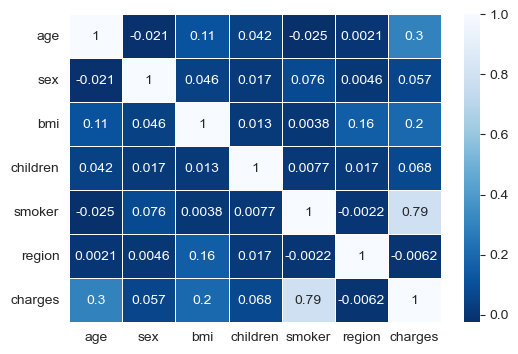

In [8]:
fig, ax = plt.subplots(figsize = (6,4))

ax = sns.heatmap(df.corr(), cmap="Blues_r", annot=True, linewidths=0.5)

### Comments

Key correlations with dependent variable:
- smoker (0.79)
- age (0.30)
- bmi (0.20)

Key pairs of collinearity:
- bmi-region (0.16)

<br>

## Dependent Variable

Text(0, 0.5, 'Frequency')

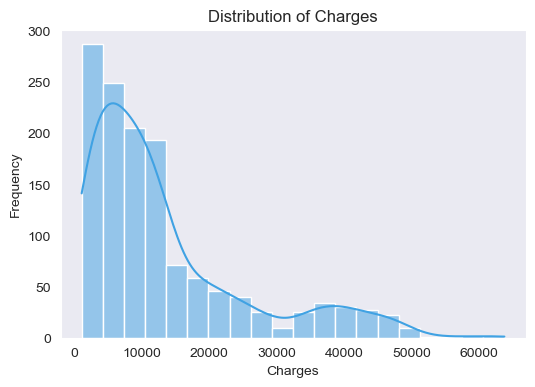

In [9]:
# Distribution of dependent variable.

fig, axes = plt.subplots(figsize=(6,4))

sns.histplot(data=df, x="charges", color='#40A2E3', bins=20, kde=True)

plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')

<br>

The charges are heavily concentrated in the lower range (about \\$0-\\$15000) before dropping off significantly. We can see that from the data descriptions presented earlier that the mininum charge is \\$1121 and the maximum is \\$63770. The average cost of insurance is \\$13270. 

<br>

## Independent Variables

### Smoking & Sex

In [10]:
# Finding the mean differences between smokers and non-smokers.

df[df['smoker'] == 1].mean() - df[df['smoker'] == 0].mean()

age           -0.87
sex            0.09
bmi            0.06
children       0.02
smoker         1.00
region        -0.01
charges    23615.96
dtype: float64

<br>

We can see a monumental difference between the insurance charges of smokers and non-smokers. Smokers pay on average nearly \\$24000 more than non-smokers. We can see that the sex-gap is in favor of males and the age is slightly lower, but the other variables are all rather constant.

<br>

In [11]:
# Non-smoking women.

df[(df['smoker']==0) & (df['sex']==0)].describe()

,age,sex,bmi,children,smoker,region,charges
count,547.00,547.00,547.00,547.00,547.00,547.00,547.00
mean,39.69,0.00,30.54,1.09,0.00,1.53,8762.30
std,14.03,0.00,5.90,1.20,0.00,1.12,6060.78
min,18.00,0.00,16.82,0.00,0.00,0.00,1607.51
25%,27.00,0.00,26.36,0.00,0.00,1.00,4265.60
50%,40.00,0.00,30.21,1.00,0.00,2.00,7639.42
75%,52.00,0.00,34.31,2.00,0.00,3.00,11786.17
max,64.00,0.00,48.07,5.00,0.00,3.00,36910.61


In [12]:
# Non-smoking men.

df[(df['smoker']==0) & (df['sex']==1)].describe()

,age,sex,bmi,children,smoker,region,charges
count,517.00,517.00,517.00,517.00,517.00,517.00,517.00
mean,39.06,1.00,30.77,1.09,0.00,1.50,8087.20
std,14.15,0.00,6.19,1.23,0.00,1.11,5908.11
min,18.00,1.00,15.96,0.00,0.00,0.00,1121.87
25%,26.00,1.00,26.22,0.00,0.00,1.00,3659.35
50%,39.00,1.00,30.50,1.00,0.00,2.00,6985.51
75%,51.00,1.00,34.43,2.00,0.00,2.00,10959.33
max,64.00,1.00,53.13,5.00,0.00,3.00,32108.66


In [13]:
# Smoking women.

df[(df['smoker']==1) & (df['sex']==0)].describe()

,age,sex,bmi,children,smoker,region,charges
count,115.00,115.00,115.00,115.00,115.00,115.00,115.00
mean,38.61,0.00,29.61,1.01,1.00,1.43,30679.00
std,14.22,0.00,6.66,1.14,0.00,1.06,11907.54
min,18.00,0.00,17.20,0.00,1.00,0.00,13844.51
25%,26.50,0.00,24.65,0.00,1.00,0.50,19696.43
50%,39.00,0.00,28.38,1.00,1.00,1.00,28950.47
75%,48.50,0.00,34.35,2.00,1.00,2.00,40918.31
max,64.00,0.00,47.60,5.00,1.00,3.00,63770.43


In [14]:
# Smoking men.

df[(df['smoker']==1) & (df['sex']==1)].describe()

,age,sex,bmi,children,smoker,region,charges
count,159.00,159.00,159.00,159.00,159.00,159.00,159.00
mean,38.45,1.00,31.50,1.19,1.00,1.57,33042.01
std,13.75,0.00,5.95,1.17,0.00,1.09,11202.67
min,18.00,1.00,17.29,0.00,1.00,0.00,12829.46
25%,27.00,1.00,27.36,0.00,1.00,1.00,21241.53
50%,38.00,1.00,31.13,1.00,1.00,2.00,36085.22
75%,49.50,1.00,35.56,2.00,1.00,2.00,41797.59
max,64.00,1.00,52.58,4.00,1.00,3.00,62592.87


<br>

### Key observations

- Non-smokers far outnumber smokers
- Men smoke more than women
- Smoking men cost the most, non-smoking men cost the least
- Smoking men have the most children
- Smoking men and smoking women seem to have regional differences

Let's visualize these findings through some histograms.

<br>

Text(0.5, 1.0, 'By Sex')

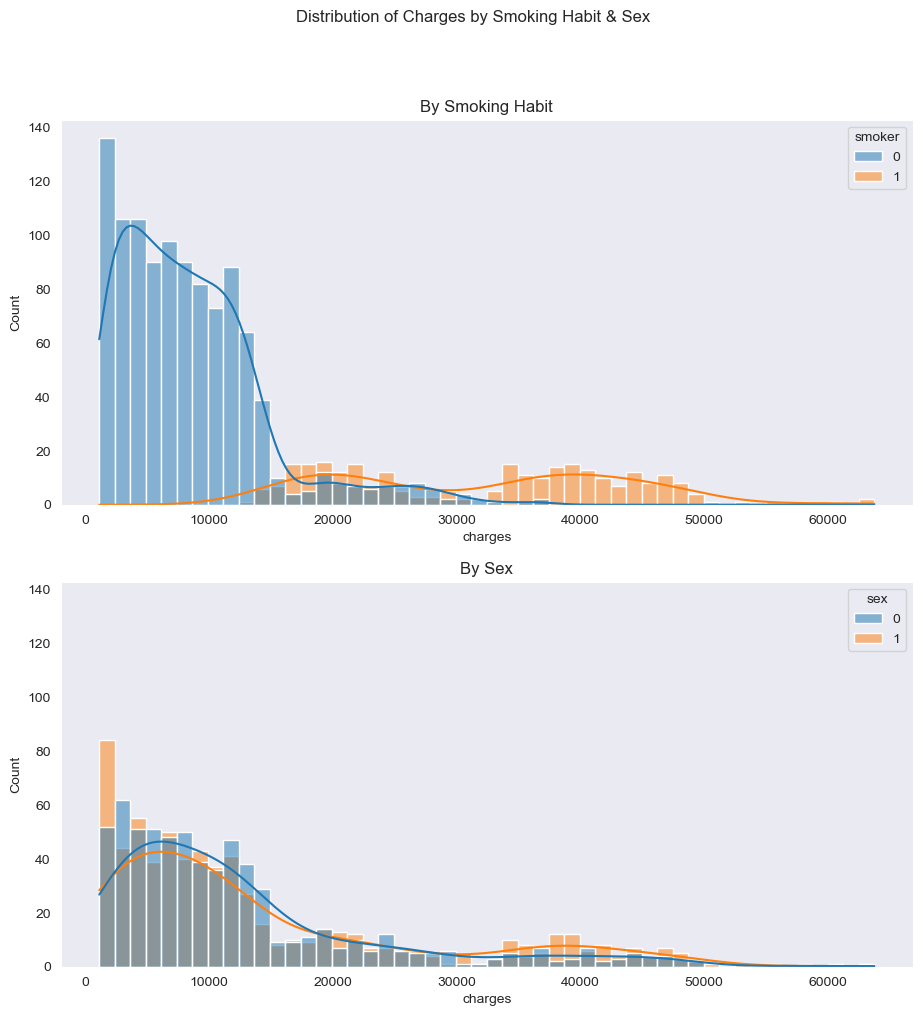

In [15]:
# Charges by the two binary variables: smoker and sex.
# Smoker: 0 is non-smoker, 1 is smoker
# Sex: 0 is female, 1 is male

fig, axes = plt.subplots(2, 1, figsize=(11,11), sharey=True)

sns.histplot(data=df, x="charges", hue="smoker", bins=50, ax=axes[0], kde=True, legend=True)
sns.histplot(data=df, x="charges", hue="sex", bins=50, ax=axes[1], kde=True, legend=True)

plt.suptitle("Distribution of Charges by Smoking Habit & Sex")
axes[0].set_title("By Smoking Habit")
axes[1].set_title("By Sex")

### Comments

Let us split the data into three cost strata:
- Low-cost: 0-15000
- Medium-cost: 15001-30000
- High-cost: 30000+

There are two visible humps for smokers (orange). This implies that they can be categorized into two groups: those who develop health issues and those who do not. The high-cost hump is likely those who <i>do</i> develop smoking-related health issues and the medium-cost hump must be those who do <i>not</i>. 

While it is not clear what these health issues for smokers may specifically be, the graph evidently shows a split in the data and will likely be reflected in the remaining variables as well. Non-smokers solely have a (very large) low-cost hump before the frequency falls off beyond \\$15000, which suggests that they are highly unlikely to develop long-standing or expensive health issues.

With regards to sex, men and women have nearly identical charts for costs. Men are marginally more likely to be high-cost (\\$30000-\\$50000) and women are marginally more likely to be low-cost (\\$0-\\$15000).

Text(0.5, 1.0, 'Smoking Women')

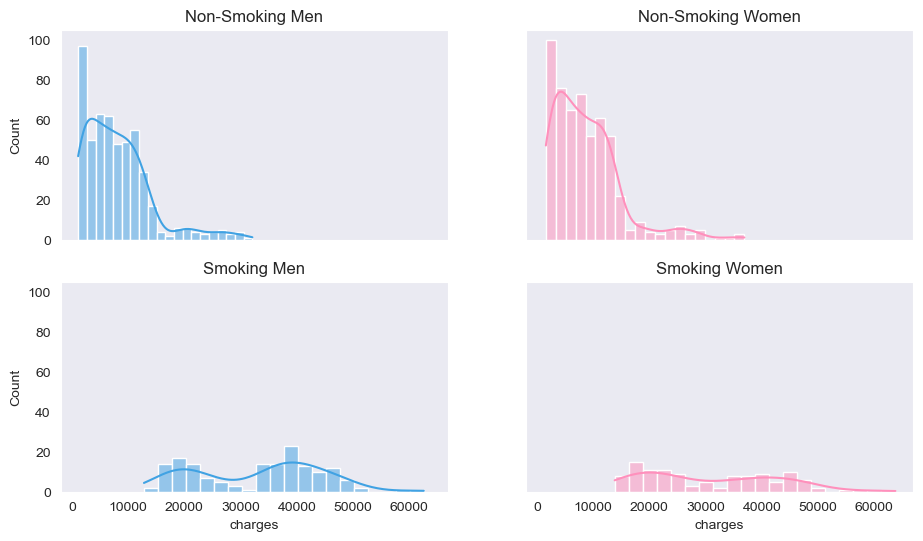

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(11,6), sharey=True, sharex=True)

sns.histplot(df[(df['sex']==1) & (df['smoker']==0)], x='charges', color='#40A2E3', ax=axes[0,0], bins=20, kde=True)
sns.histplot(df[(df['sex']==0) & (df['smoker']==0)], x='charges', color='#FF90BC', ax=axes[0,1], bins=20, kde=True)
sns.histplot(df[(df['sex']==1) & (df['smoker']==1)], x='charges', color='#40A2E3', ax=axes[1,0], bins=20, kde=True)
sns.histplot(df[(df['sex']==0) & (df['smoker']==1)], x='charges', color='#FF90BC', ax=axes[1,1], bins=20, kde=True)

axes[0,0].set_title("Non-Smoking Men")
axes[0,1].set_title("Non-Smoking Women")
axes[1,0].set_title("Smoking Men")
axes[1,1].set_title("Smoking Women")

Text(0.5, 1.0, 'Charges of Men by Smoking Habit')

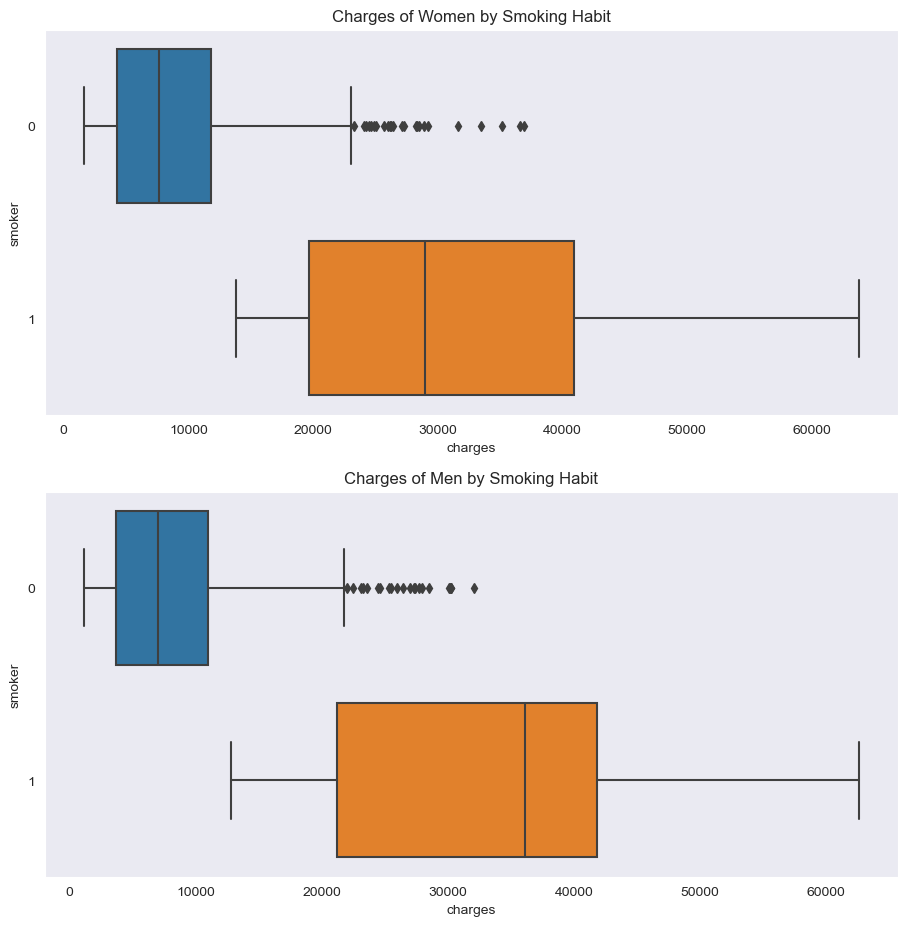

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(11,11))

sns.boxplot(y='smoker', x='charges', data=df[(df.sex == 0)], ax=axes[0], orient='h')
sns.boxplot(y='smoker', x='charges', data=df[(df.sex == 1)], ax=axes[1], orient='h')

axes[0].set_title('Charges of Women by Smoking Habit')
axes[1].set_title('Charges of Men by Smoking Habit')

### Comments

The patterns for both men and women are similar. 

- Smokers cost more than non-smokers for both sexes
- Non-smokers have the same distribution for both sexes
- Smoking men have more pronounced humps for their insurance costs and a higher median cost in general. This corresponds with the earlier finding of men being more likely to smoke than women.

### Smoking & Age

Text(0.5, 1.0, 'Smokers')

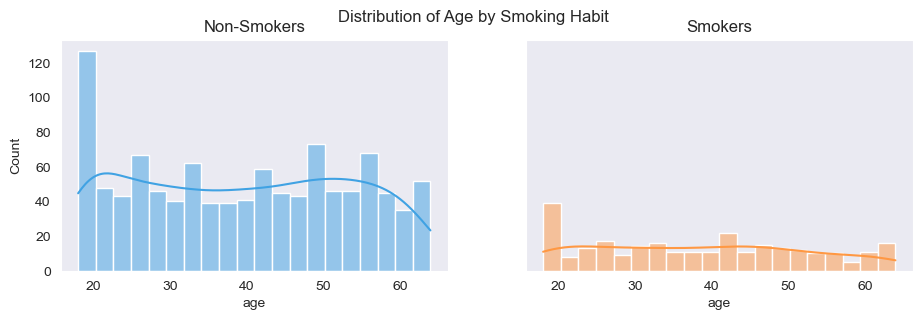

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(11,3), sharey=True, sharex=True)

sns.histplot(data=df[df['smoker']==0], x='age', color='#40A2E3', ax=axes[0], bins=20, kde=True, legend=True)
sns.histplot(data=df[df['smoker']==1], x='age', color='#FF9843', ax=axes[1], bins=20, kde=True, legend=True)

plt.suptitle("Distribution of Age by Smoking Habit")
axes[0].set_title("Non-Smokers")
axes[1].set_title("Smokers")

Text(0.5, 1.0, 'By Sex')

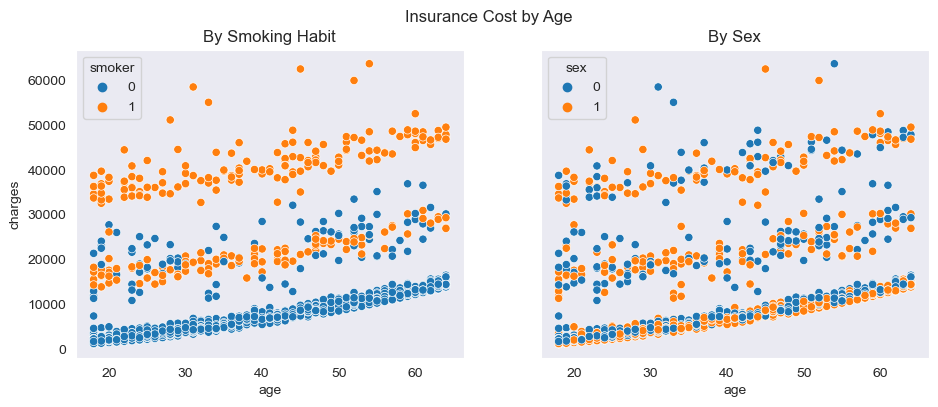

In [19]:
# Age.

fig, axes = plt.subplots(1, 2, figsize=(11,4), sharey=True)

sns.scatterplot(data=df, x='age', y='charges', hue='smoker', ax=axes[0], legend=True)
sns.scatterplot(data=df, x='age', y='charges', hue='sex', ax=axes[1], legend=True)

plt.suptitle("Insurance Cost by Age")
axes[0].set_title("By Smoking Habit")
axes[1].set_title("By Sex")

<br>

### Comments

Similar patterns as we saw before. Low-cost is mostly non-smokers, medium-cost is a mix and high-cost is almost entirely smokers. Cost-per-age steadily rises for all three cost ranges - not surprising since health issues increase with age.

No noticeable patterns by sex. 

<br>

### Smoking & BMI

Text(0.5, 1.0, 'Smokers')

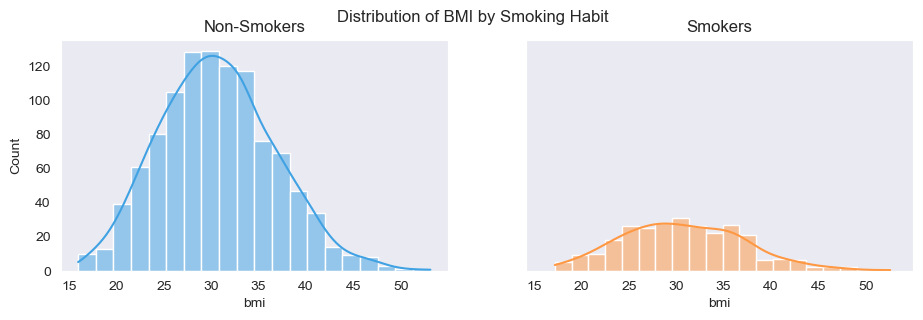

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(11,3), sharey=True, sharex=True)

sns.histplot(data=df[df['smoker']==0], x='bmi', color='#40A2E3', ax=axes[0], bins=20, kde=True)
sns.histplot(data=df[df['smoker']==1], x='bmi', color='#FF9843', ax=axes[1], bins=20, kde=True)

plt.suptitle("Distribution of BMI by Smoking Habit")
axes[0].set_title("Non-Smokers")
axes[1].set_title("Smokers")

Text(0.5, 1.0, 'By Sex')

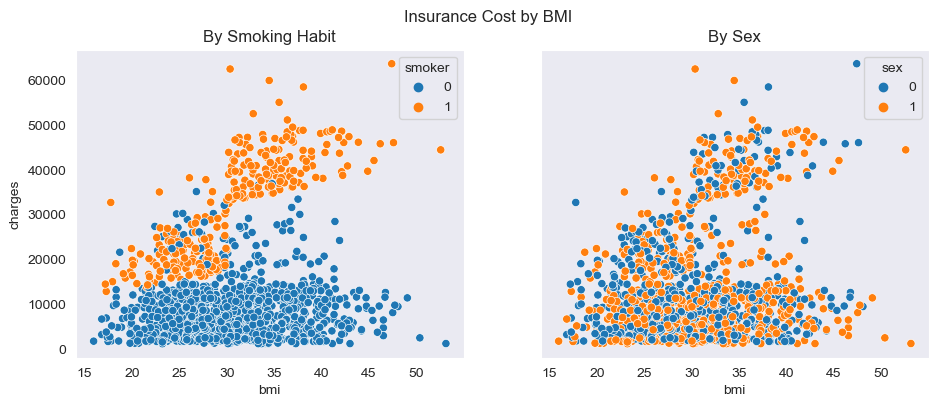

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(11,4), sharey=True)

sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', ax=axes[0], legend=True)
sns.scatterplot(data=df, x='bmi', y='charges', hue='sex', ax=axes[1], legend=True)

plt.suptitle("Insurance Cost by BMI")
axes[0].set_title("By Smoking Habit")
axes[1].set_title("By Sex")

<br>

### Comments

The distribution of BMI for smokers and non-smokers follow a standard Gaussian distribution. The scatterplots demonstrate that smokers tend to have a far higher BMI than non-smokers. There are no major differences between Sex and BMI.

These findings are not surprising. Smoking is known to have adverse health effects, which likely contribute to weight gain. Women and men are equally likely to gain weight as the key differentiator here is smoking habit rather than sex.

<br>

## Collinearity Analysis

As we had seen earlier, there was one key instance of collinearity: bmi-region. The value of collinearity was quite low (0.16), but it may still be useful to visualize the differences.

<br>

Text(0.5, 1.0, 'Southwest')

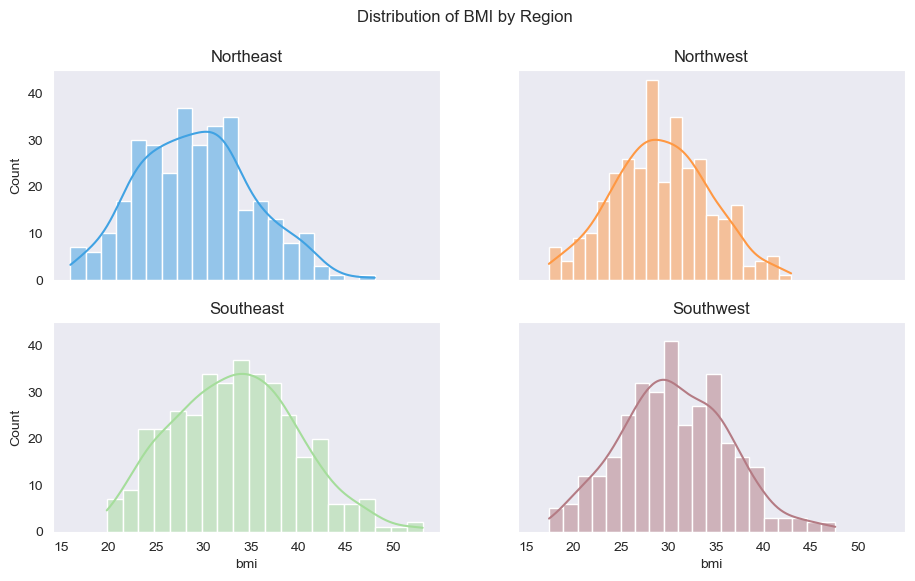

In [22]:
# BMI & Region

fig, axes = plt.subplots(2, 2, figsize=(11,6), sharey=True, sharex=True)

sns.histplot(data=df[df['region']==0], x='bmi', color='#40A2E3', ax=axes[0,0], bins=20, kde=True)
sns.histplot(data=df[df['region']==1], x='bmi', color='#FF9843', ax=axes[0,1], bins=20, kde=True)
sns.histplot(data=df[df['region']==2], x='bmi', color='#A5DD9B', ax=axes[1,0], bins=20, kde=True)
sns.histplot(data=df[df['region']==3], x='bmi', color='#B47B84', ax=axes[1,1], bins=20, kde=True)

plt.suptitle("Distribution of BMI by Region")
axes[0,0].set_title("Northeast")
axes[0,1].set_title("Northwest")
axes[1,0].set_title("Southeast")
axes[1,1].set_title("Southwest")

### Comments

There are no serious discrepancies between the regions. All four regions follow a Gaussian distribution with some mild shifts in mean or skew.

## Identifying Most Affordable Customer

Judging by the earlier results, a customer would be most affordable if they fit the following descriptions:
- Young
- Low BMI
- Non-Smoker

Let's take a look at the regions which have customers who fit this description.

Text(0.5, 1.0, 'Southwest')

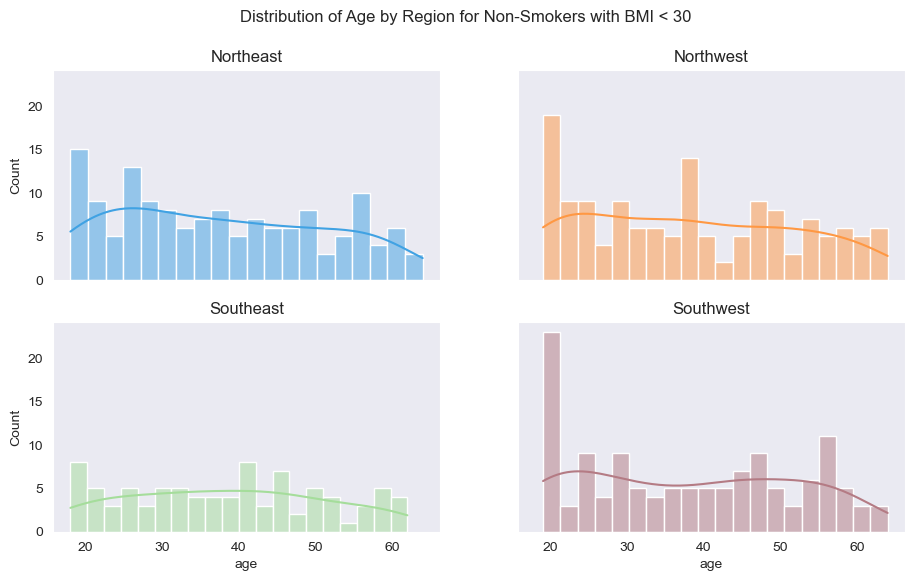

In [23]:
# Age distribution by region for non-smokers with BMI < 30.

fig, axes = plt.subplots(2, 2, figsize=(11,6), sharey=True, sharex=True)

sns.histplot(data=df[(df['region']==0) & (df['bmi'] < 30) & (df['smoker']==0)], x='age', color='#40A2E3', ax=axes[0,0], bins=20, kde=True)
sns.histplot(data=df[(df['region']==1) & (df['bmi'] < 30) & (df['smoker']==0)], x='age', color='#FF9843', ax=axes[0,1], bins=20, kde=True)
sns.histplot(data=df[(df['region']==2) & (df['bmi'] < 30) & (df['smoker']==0)], x='age', color='#A5DD9B', ax=axes[1,0], bins=20, kde=True)
sns.histplot(data=df[(df['region']==3) & (df['bmi'] < 30) & (df['smoker']==0)], x='age', color='#B47B84', ax=axes[1,1], bins=20, kde=True)

plt.suptitle("Distribution of Age by Region for Non-Smokers with BMI < 30")
axes[0,0].set_title("Northeast")
axes[0,1].set_title("Northwest")
axes[1,0].set_title("Southeast")
axes[1,1].set_title("Southwest")

### Comments

In order to maximize profit, one would imagine that the hypothetical insurance company in question would prefer to discriminate by region (as is normal practice in the industry). Regions with better demographics can be given a discount, whereas regions with worse demographics can be charged a premium. Non-smoking youth (Age < 35) with a relatively lower BMI (BMI < 30) ought to be prime target for a discount as they are the least likely to be ill in their life. This does assume, however, that this dataset is a <i>complete</i> dataset for the regions. In most cases, this assumption would be unlikely to hold true.

If we are to argue for regional preferences for marketing a discount, the order of preference ought to be:

1. Southwest
2. Northeast
3. Northwest
4. Southeast

## Identifying Most Expensive Customer

Likewise, the most expensive customers ought to fit the following criteria:
- Old
- Male
- Smokers

Text(0.5, 1.0, 'Southwest')

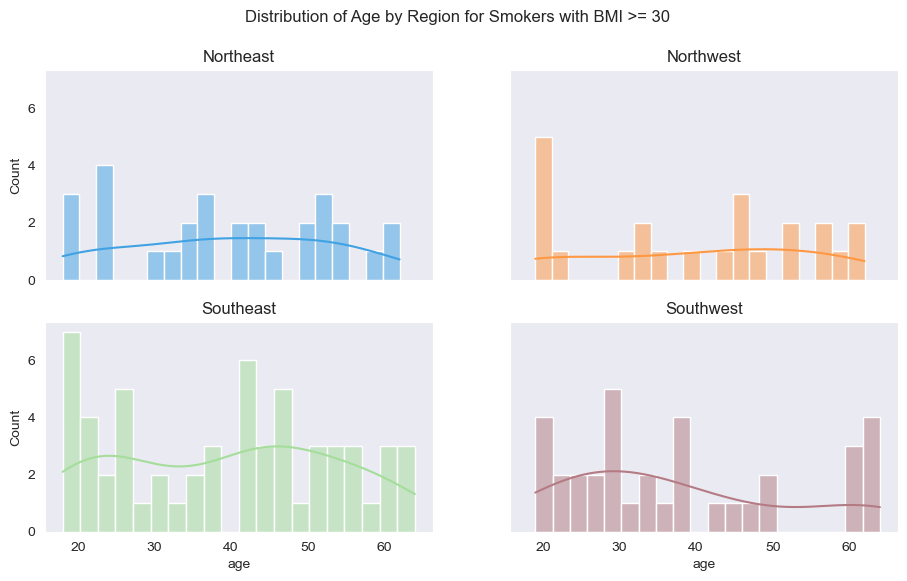

In [24]:
# Age distribution by region for smokers.

fig, axes = plt.subplots(2, 2, figsize=(11,6), sharey=True, sharex=True)

sns.histplot(data=df[(df['region']==0) & (df['bmi'] >= 30) & (df['smoker']==1)], x='age', color='#40A2E3', ax=axes[0,0], bins=20, kde=True)
sns.histplot(data=df[(df['region']==1) & (df['bmi'] >= 30) & (df['smoker']==1)], x='age', color='#FF9843', ax=axes[0,1], bins=20, kde=True)
sns.histplot(data=df[(df['region']==2) & (df['bmi'] >= 30) & (df['smoker']==1)], x='age', color='#A5DD9B', ax=axes[1,0], bins=20, kde=True)
sns.histplot(data=df[(df['region']==3) & (df['bmi'] >= 30) & (df['smoker']==1)], x='age', color='#B47B84', ax=axes[1,1], bins=20, kde=True)

plt.suptitle("Distribution of Age by Region for Smokers with BMI >= 30")
axes[0,0].set_title("Northeast")
axes[0,1].set_title("Northwest")
axes[1,0].set_title("Southeast")
axes[1,1].set_title("Southwest")

<br>

Given the above data, one would easily identify the Southeast region as the one most prone to high insurance costs and unhealthy demographics. The Southwest region also has some heavy, smoking seniors with another large cohort (around age 38-40) steadily moving up the list. This ought to be the second region identified for price discrimination. The Northeast has a larger cohort around age 40-50 with the Northwest being the least profitable for premiums.

Therefore, the order of preference ought to be:
- Southeast
- Southwest
- Northeast
- Northwest

# Modeling the Data

Now that we've taken a look at the four factors which are crucial to determining the cost of insurance, let us build a model that can successfully estimate the cost of an arbitrary individual's insurance. Given that the data is continuous, we will be experimenting with linear regression models.

<br>

## Ordinary Least Squares

In [25]:
X = df.drop(['charges'], axis = 1)
y = df.charges

In [26]:
X.head()

,age,sex,bmi,children,smoker,region
0,19,0,27.90,0,1,3
1,18,1,33.77,1,0,2
2,28,1,33.00,3,0,2
3,33,1,22.70,0,0,1
4,32,1,28.88,0,0,1


In [27]:
y.head()

0   16884.92
1    1725.55
2    4449.46
3   21984.47
4    3866.86
Name: charges, dtype: float64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

lr = LinearRegression().fit(X_train, y_train)

In [29]:
print("Coefficient: {}".format(lr.coef_))
print("Intercept: {:.2f}".format(lr.intercept_))

Coefficient: [  252.07830816  -270.1850953    316.55473012   364.49255776
 24069.87438208  -259.23126409]
Intercept: -11074.75


In [30]:
print("Training set score: {:.3f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr.score(X_test, y_test)))

Training set score: 0.755
Test set score: 0.734


<br>

A test-set score of 0.734 isn't great but it's not particularly bad either. Let's see if regularization of variables makes any difference. Given that there are only 6 variables to begin with, I don't think we can expect much change.

<br>

## L2 Regularization

In [31]:
# Alpha of 0.1.

ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)

print("Training set score: {:.3f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.3f}".format(ridge01.score(X_test, y_test)))

Training set score: 0.755
Test set score: 0.734


In [32]:
# Alpha of 1.

ridge02 = Ridge(alpha=1).fit(X_train, y_train)

print("Training set score: {:.3f}".format(ridge02.score(X_train, y_train)))
print("Test set score: {:.3f}".format(ridge02.score(X_test, y_test)))

Training set score: 0.755
Test set score: 0.734


In [33]:
# Alpha of 10.

ridge03 = Ridge(alpha=10).fit(X_train, y_train)

print("Training set score: {:.3f}".format(ridge03.score(X_train, y_train)))
print("Test set score: {:.3f}".format(ridge03.score(X_test, y_test)))

Training set score: 0.753
Test set score: 0.735


In [34]:
# Alpha of 100.

ridge04 = Ridge(alpha=100).fit(X_train, y_train)

print("Training set score: {:.3f}".format(ridge04.score(X_train, y_train)))
print("Test set score: {:.3f}".format(ridge04.score(X_test, y_test)))

Training set score: 0.665
Test set score: 0.662


<br>

The value of alpha is raised to force the parameters closer to a value of zero. We can see, however, that the raising of alpha to 100 is a detriment to both the training and test scores. The ideal model seems to possess an alpha of 10, where the test score of 0.735 is slightly higher than the OLS score of 0.734.

<br>

## L1 Regularization

In [35]:
# Alpha of 0.1.

lasso01 = Lasso(alpha=0.1).fit(X_train, y_train)
print("Training set score: {:.3f}".format(lasso01.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso01.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso01.coef_ != 0)))

Training set score: 0.755
Test set score: 0.734
Number of features used: 6


In [36]:
# Alpha of 1.

lasso02 = Lasso(alpha=1).fit(X_train, y_train)
print("Training set score: {:.3f}".format(lasso02.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso02.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso02.coef_ != 0)))

Training set score: 0.755
Test set score: 0.734
Number of features used: 6


In [37]:
# Alpha of 10.

lasso03 = Lasso(alpha=10).fit(X_train, y_train)
print("Training set score: {:.3f}".format(lasso03.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso03.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso03.coef_ != 0)))

Training set score: 0.755
Test set score: 0.734
Number of features used: 6


In [38]:
# Alpha of 100.

lasso04 = Lasso(alpha=100).fit(X_train, y_train)
print("Training set score: {:.3f}".format(lasso04.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso04.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso04.coef_ != 0)))

Training set score: 0.754
Test set score: 0.734
Number of features used: 5


In [41]:
# Alpha of 500.

lasso05 = Lasso(alpha=500).fit(X_train, y_train)
print("Training set score: {:.3f}".format(lasso05.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso05.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso05.coef_ != 0)))

Training set score: 0.743
Test set score: 0.722
Number of features used: 4


In [42]:
# Alpha of 1000.

lasso06 = Lasso(alpha=1000).fit(X_train, y_train)
print("Training set score: {:.3f}".format(lasso06.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso06.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso06.coef_ != 0)))

Training set score: 0.713
Test set score: 0.697
Number of features used: 3


<br>

Once again, the raising of alpha seems to be a detriment beyond 100. The difference between the use of 6 or 5 variables doesn't seem to make a difference in scores. Once we arrive at a model with 3 or 4 variables, the test and training scores begin to fall. It might be better to keep the alpha at 10 and leave the model with 6 variables. The test score of 0.734 is identical to the OLS model and slightly lower than the L1 model.

<br>

# Conclusion

This project involved the exploration of a dataset containing the insurance costs of individual patients. The individuals were separated by six categories. Of these categories, it was found that Smoking is the most important factor in predicting insurance costs (with a correlation of 0.79). Older, heavier smoking males were the demographic most liable to high costs whereas younger, lighter non-smoking males were the least liable to high costs. Some mild collinearity exists between BMI and Region, which could suggest patterns in living quality, but the discrepancy wasn't particularly serious. 

Linear regression was used to develop a predictive model for the data. The ordinary least squares method yielded an R<sup>2</sup> of 0.734. Regularization still maintained the value at a near-identical level. When the hyperparameter is raised for both forms of regularization, the test score begins to decrease beyond an alpha of 10. L1 regularization also works best with all 6 variables in the model. It doesn't seem to matter which of these three models are chosen as the predictive power of the models remain the same.

In conclusion, it is reasonably possible to predict the insurance cost of individual subjects with this data, but the predictive ability of the data does not seem to suit a strong Linear Regression model. Ideally, we'd want a model with an R<sup>2</sup> above 90. Perhaps the collection of further data points or different variables would yield a more favorable model.

Finis.